In [2]:
import numpy as np
import pathlib
cwd = pathlib.Path.cwd()
import pandas
import itertools
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as snes

from PIL import Image
import imageio
import pickle
import GeneClass as Gene
import random
import shutil

kmer = 6
# print(np.sqrt(4**kmer))
matplotlib.rc('figure', figsize=(6, 6), dpi = np.sqrt(4**kmer))


In [3]:
def float_for(start: float, stop: float, number_of_steps: int = 10, resolution: int = 1):
    '''
    does a for loop for floating points.

    if the number of steps is odd you will get [start, stop), while if it is odd you will get [start, stop]. Sort of. This is greatly influenced by the resolution.

    resolution is how the numbers should be rounded. Since we're dealing with floating points sometimes things can get a little weird.
    '''
    # steps = int(((stop - start) / step_size) + 1)

    step_size = round((stop - start) / number_of_steps, resolution)

    print(start, stop, number_of_steps, resolution, step_size)

    # for s in range(number_of_steps):
    #     yield round(start + s*step_size, resolution)
    s = start
    # while s < stop:
    #     yield s += step_size


def save_Image(data: np.ndarray, save: pathlib.Path):
    '''
    '''
    max_norm = data.max()
    scale = 255 / max_norm
    data = (data * scale).astype("uint8")
    image = Image.fromarray(data)
    image.save(save)

def plot_heatmap_test(data: np.ndarray, save: pathlib.Path = None):
    '''
    '''
    # Seaborn version
    plt.close()
    ax = snes.heatmap(data, cbar = False, cmap="Greys_r")
    ax.axis("off")
    if isinstance(save, pathlib.Path):
        plt.savefig(save, bbox_inches = "tight", pad_inches = 0)
    plt.show()


    # Matplotlib version
    # plt.close()
    # # plt.margins(x=0)
    # fig, ax = plt.subplots()
    # plt.imshow(data, cmap='gray', interpolation='nearest')
    # plt.axis("off")
    # # ax = fig.add_subplot()
    # # ax.set_axis_off()
    # # plt.colorbar()
    # ax.axis("tight")
    # if isinstance(save, pathlib.Path):
    #     plt.savefig(save)
    # plt.show()


def plot_heatmap(data: np.ndarray):
    '''
    '''
    plt.close()
    plt.imshow(data, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.show()  


def plot_image(xy: np.ndarray, save: str = None):
    '''
    '''
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_axis_off()
    plt.scatter(xy[:, 0], xy[:, 1], color = "black", s = 0.5)

    if isinstance(save, pathlib.Path):
        fig.savefig(str(save))
    else:
        fig.show()



def gaussian(xy: np.ndarray, t: np.ndarray, delta: int = 2, *args, **kwargs) -> np.array:
    '''
    Takes in two arrays, a point-set array and a grid array. The xy should be a Nx2 size vector:

    N = number of points
   means [x, y]

    while the tz one is a 1D vector [t] that represents one column/row. It will iterate across this as such:
    for tx in t:
        for ty in t:
            T = tx X + ty Y

    delta is how many steps to take on the grid. the conversion from delta to sigma is:
    sigma = delta * (1 - 0) / (grid length)

    Look over the notes you took with Dr G... something is confusing about the normalization
    '''
    if isinstance(delta, int):
        if delta < 1:
            delta = 1 # in case someone puts in a sigma value of 0
        sigma = t[delta]  # it actually just pulls from the delta row to get the step size
    elif isinstance(delta, float):
        sigma = delta

    sigma_sqr = np.dot(sigma, sigma)

    m = t.shape[0]
    field = np.zeros((m, m))
    N = xy.shape[0]
    # N = m * m

    for x in xy:
        P = list()
        Np = 0
        for ix, tx in enumerate(t):
            for iy, ty in enumerate(t[::-1]):
                T = np.array([tx, ty])
                d = np.linalg.norm(x - T)
                if d < sigma:
                    p = np.exp((-1/2) * np.dot(d, d) / sigma_sqr)
                    Np += p
                    P.append([p, iy, ix])

        for p in P:
            field[p[1], p[2]] += p[0] / Np


    # print(field)
    # print(np.sum(field))

    field = field / N

    return field


def gaussian_optimized(xy: np.ndarray, t: np.ndarray, delta: int = 2, *args, **kwargs) -> np.array:
    '''
    Takes in two arrays, a point-set array and a grid array. The xy should be a Nx2 size vector:

    N = number of points
   means [x, y]

    while the tz one is a 1D vector [t] that represents one column/row. It will iterate across this as such:
    for tx in t:
        for ty in t:
            T = tx X + ty Y

    delta is how many steps to take on the grid. the conversion from delta to sigma is:
    sigma = delta * (1 - 0) / (grid length)

    Look over the notes you took with Dr G... something is confusing about the normalization
    '''
    if isinstance(delta, int):
        if delta < 1:
            delta = 1 # in case someone puts in a sigma value of 0
        sigma = t[delta]  # it actually just pulls from the delta row to get the step size
    elif isinstance(delta, float):
        sigma = delta

    sigma_sqr = np.dot(sigma, sigma)

    m = t.shape[0]
    field = np.zeros((m, m))
    N = xy.shape[0]
    N = m * m

    G = [[x, y] for x in t for y in t]
    G = np.array(G)

    for gi, g in enumerate(G):
        D = np.linalg.norm(g - xy, axis = 1)
        D = D[D < sigma]
        p = np.sum(np.exp((-1/2) * np.power(D, 2) / sigma_sqr))
        iy, ix = int(gi / m), gi % m
        field[ix, iy] += p

    field = field / np.sum(field)
    field = np.flip(field, axis = 0)  # for some reason it's flipped on the y axis. Probably beause the bottom is the top is row 0 but we want the bottom to be row 0

    return field


def time_embedding(sequence: str, 
                      k_p: int = 6, k_m: int = 6, gap: int = 0, 
                      m_backwards: bool = True, p_backwards: bool = False, 
                      nucsequence: str = "AGTC",
                      *args, **kwargs):
    '''
    Feeds in a sequence, and it finds the xy coordinates for that sequence.

    The nucleotide to number order can be altered. By default it is A = 0, G = 1, T = 2, C = 3. To alter it just feed in a new str with your prefered order. The first index is 0, the next
    index is 1, and so on.

    There is an option for the compliment strand: probably should never be used.
    '''
    sequence = sequence.upper()
    nucsequence = nucsequence.upper() # Just in case someone puts in a different order and forgets to capitalize everything
    seq_length = len(sequence)

    if seq_length < (k_m + k_p + abs(gap)):  # I'm making this an |gap| becuase I don't want to think about how it should be done if g < 0. It has to be a certain length, and that length needs to be long.
        print("Cannont find Trajectory for this gene: to small")
        return None

    w_p = [(0.25)**n for n in range(1, k_p + 1)]
    w_m = [(0.25)**n for n in range(1, k_m + 1)]

    if m_backwards:
        w_m.reverse()
    if p_backwards:
        w_p.reverse()

    xy = np.zeros(shape=(seq_length - (k_p + k_m + gap), 2))

    k_minus = [sequence[k_prime:k_prime + k_m] for k_prime in range(0, seq_length - (k_p + k_m + gap))]
    k_plus = [sequence[k_prime:k_prime + k_p] for k_prime in range(gap + k_m, seq_length - k_p)]

    for i, k_prime in enumerate(k_minus):
        n = [0 if n in nucsequence[0] else 1 if n in nucsequence[1] else 2 if n in nucsequence[2] else 3 if n in nucsequence[3] else 100 for n in k_prime]
        k_x = np.dot(w_m, n)

        n = [0 if n in nucsequence[0] else 1 if n in nucsequence[1] else 2 if n in nucsequence[2] else 3 if n in nucsequence[3] else 100 for n in k_plus[i]]
        k_y = np.dot(w_p, n)

        xy[i][0], xy[i][1] = k_y, k_x

    return xy


In [4]:
xy = np.random.rand(50,2)

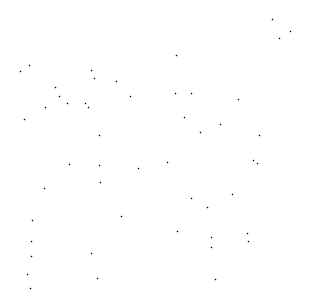

In [5]:
plot_image(xy, save = cwd / "Fractal_Random.png")

[[1. 4. 0.]
 [0. 1. 0.]
 [0. 0. 3.]]
[[0. 0. 3.]
 [0. 1. 0.]
 [1. 4. 0.]]
1.0000000000000002


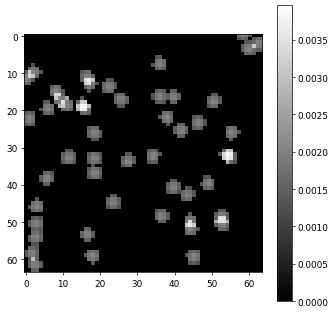

In [6]:
scale = 10**-6

# something = float_for(0, 1, number_of_steps=10, resolution=1)
delta = (1 - 0) / np.sqrt(4**kmer)
grid = np.arange(0, 1, delta)

# something = list()
# for x in grid:
#     for y in grid:
#         something.append([x, y])  # Can't really figure out how to do this via list comprehension.

# grid = np.array(something)
# print(grid)
# print(grid.shape[0])
# print(grid[1][1])
# print(grid[grid.shape[0] - 1][1] + grid[1][1])
# print((1 - 0) / np.sqrt(4**kmer))
# sigma = 3
# sigma_squared = np.dot(sigma, sigma)
# n = 1 / np.sqrt(2 * np.pi * sigma)
# N = xy.shape[0]
# N = n / N

diag = np.zeros((3, 3))
diag[0, 0], diag[1, 1], diag[2, 2] = 1, 1, 3
diag[0, 1] = 4
print(diag)
diag = np.flip(diag, axis = 0)
print(diag)

something = gaussian_optimized(xy, grid)
print(something.sum())
plot_heatmap(something)

1.0


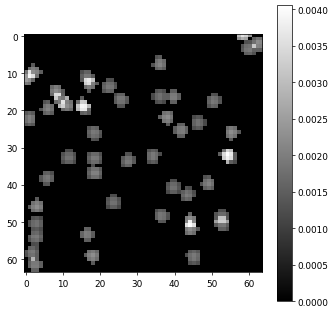

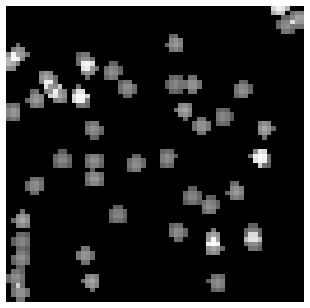

In [7]:
something: np.ndarray = gaussian(xy, grid, delta = 2)
print(something.sum())
plot_heatmap(something)
plot_heatmap_test(something)

In [8]:
exon_sample = "GCTGGAGCTGCCCGCCGACCTCCTGCGGCAGAAGGAGCTGGAGAGCGCGCGCCCACAGCTGCTGGCGCCCGAGACCGCCCTGCGCCCCAACGACGGCGCCGAGGAGCTGCAGCGGCGCGGGGCCCTGCTGGTGCTGAACCACGGCGCGGCGCCACTGCTGGCCCTGCCCCCCCAGGGGCCCCCGGGCTCCGGACCCCCCACCCCGTCCCGGGACTCTGCCCGGCGAGCCCCCCGGAAGGGGGGTCCCGGCCCTGCCTCAGCGCGGCCCAGCGAGTCCAAGGAGATGACGGGGGCTAGGCTCTGGGCACAAGATGGCTCGGAAGACGAGCCCCCCAAAGACTCGGACGGAGAGGACCCCGAGACGGCAGCTGTTGGGTGCAGGGGGCCCACTCCGGGCCAAGCTCCAGCTGGAGGGGCCGGCGCCGAGGGGAAGGGGCTTTTCCCAGGGTCCACACTGCCCCTGGGCTTCCCTTATGCCGTCAGCCCCTACTTCCACACAG"
exon_save = cwd / "GHM_Exon_2.png"
intron_sample = "gtgaggacccaccctggcatgatctcccctcatcacctccccagccacatgtactcggccattcctgttgctgaggccctgctgacaccaaggccaggctggatgcaggtccctctgccacacgtcctgccccatgccccctggggcgggccacacctccatgtcccctaggtccccagggtcatgactagctcacattttatatagagagaaatggagtctggggtggacccaggtgagggtgggcagtgggcatgtcagcagcaccccccgaggagagcaagctcctggaccctgtggtctgtgagtcgtctatgcagccagtggacgccgacctgccagacgcctgccccaggagcctggggaggggcagtgagcagaaaggccgggctgggtgcagtgggcacttggccaccaggactccccaggtgctgaagagacgccagctggaggggctgccccttcccccgggtcggccctgaccctgtccaccccacctcaggacgttctccaggggtccctccgggatgcactcggaccccctgcccgctgcactcagcctcccaggccccagccgcccgcctggcaggggagcttggcttttcgggctagaggtgggtgggggcgccgggaaaggaggcaggattcctcacaccaggcaccgtcccccagggcagctcaggcaccaagagcctgaataattcaccaaatgttaataatgtaaaaatcctcctttttaattgctttccctgctctgcctggggccgctctgctggccgcgcgggggaggggcgccggccgccggggagcgcgctgtcaatcaggccgcgccgccgccccccccccccgccccgccgcggagccggccgtaaataaccctgtaactaacccggccgctagcgcgggggcgctgggccccgctgggatcgatgcgggcggccgcgccggctgggctctgcgggctggcacccggcccggggcgggacccacctccgctttcgggtaattaatttataaacagaggcggcggtggagctggcggagcctgcatagtgggggctgcggggactcgggaggcccgggcgggagggagaggccgagagacctgggacgcggcgccttagacgcgggcgctgcgtgcgcattggggcgagtgtggccacgcgggacagtgaccctgcgcagccgggactgggcgacccctgtgctagtgtggcgtgcgtgcgcgggcgctgccttgcctttgtgacaagctttggccagccgcgtctactatggggacctcagattttcttgcctcccaccgaagagggggtcccctgggcggtcagcccctggctggcacttctggactctctcgctgccccgcaggctctgtggcctcgggacgtctgcacagccccctccccgcaaggctcagccgcctctcaggccggaagcctccaggcacccggctccccttcggggaagagcttttcccgacacttcctcgcccagcatcttgtctgccgtctcggccctgtggccgcccatcctcctgccccgtgcccgagaccagcccaggggccgagcacggccgagtggtgtggtcagttccccacctcagtgttctacgccaggacgcgggctggggaggatgagggcgcatagccggggggatcactgctgttgtcccccacccag"
intron_save = cwd / "GHM_Intron_2.png"
# intergenomic_sample = ""
# intergenomic = time_embedding(intergenomic_sample)


Exons

2 Lattice Sites

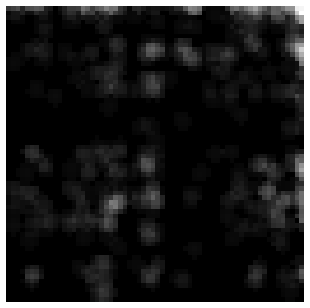

In [9]:
exon = time_embedding(exon_sample.upper())
exon_test = gaussian(exon, grid, delta = 2)
plot_image(exon, save = cwd / "Fractal_Exon.png")
plot_heatmap_test(exon_test) #, save = exon_save)
save_Image(exon_test, exon_save)

3 Lattice Sites

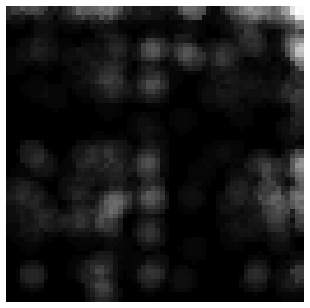

In [10]:
exon = time_embedding(exon_sample.upper())
exon_test = gaussian(exon, grid, delta = 3)
plot_heatmap_test(exon_test)

Introns

2 Lattice Sites

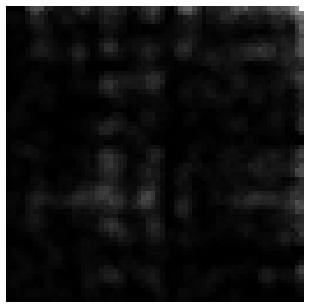

In [11]:
intron = time_embedding(intron_sample.upper())

intron_test = gaussian(intron, grid, delta = 2)
plot_image(intron, save = cwd / "Fractal_Intron.png")
plot_heatmap_test(intron_test, save = intron_save)
save_Image(intron_test, intron_save)

3 Lattice Sites

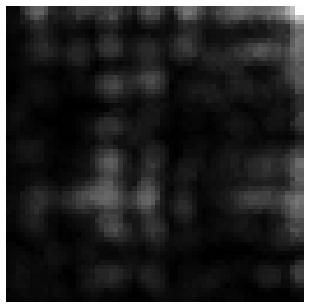

In [12]:
intron = time_embedding(intron_sample.upper())

intron_test = gaussian(intron, grid, delta = 3)
plot_heatmap_test(intron_test)

Reopen and Close images

Want to see how the values change based on the png file format

In [13]:
print(exon_test.shape)
print(np.sum(exon_test))
print(exon_test)

print(exon_test * 255)
print(np.sum(exon_test * 255))

(64, 64)
1.0
[[5.11581424e-04 6.77013758e-04 6.72392644e-04 ... 2.88897235e-03
  3.51884437e-03 3.44688644e-03]
 [4.77512687e-04 6.25233258e-04 6.22319430e-04 ... 2.92527744e-03
  3.55863742e-03 3.39264195e-03]
 [4.04603758e-04 2.28531053e-04 2.30225867e-04 ... 1.75777828e-03
  2.86791708e-03 2.94156185e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.39583779e-04
  1.72204544e-04 1.52261434e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.58121199e-05
  8.89199398e-05 7.38453117e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.38231007e-05
  7.77933426e-05 6.46050104e-05]]
[[0.13045326 0.17263851 0.17146012 ... 0.73668795 0.89730531 0.87895604]
 [0.12176574 0.15943448 0.15869145 ... 0.74594575 0.90745254 0.8651237 ]
 [0.10317396 0.05827542 0.0587076  ... 0.44823346 0.73131885 0.75009827]
 ...
 [0.         0.         0.         ... 0.06109386 0.04391216 0.03882667]
 [0.         0.         0.         ... 0.02443209 0.02267458 0.01883055]
 [0.         0.  

In [14]:
exon_png = Image.open(exon_save)
exon_png2np = np.asarray(exon_png)
exon_png_test = exon_png2np / 255
print(exon_png2np.shape)
print(exon_png2np)
print(np.sum(exon_png2np))

(64, 64)
[[ 44  50  57 ... 125 223 232]
 [  8  18  19 ...  89 174 255]
 [ 13  17  17 ...  44 109 136]
 ...
 [  0   0   0 ...   9   7   0]
 [  0   0   0 ...   8   7   0]
 [  0   0   0 ...   6   0   0]]
45834


Speed Test

In [15]:
exon_test = gaussian(exon, grid, delta = 2)

In [16]:
exon_test = gaussian_optimized(exon, grid, delta = 2)

In [17]:
intron_test = gaussian(intron, grid, delta = 2)

In [18]:
intron_test = gaussian_optimized(intron, grid, delta = 2)